# Modelos Alternativos

**Proyecto Integrador TC5035.10**

**Profesor Asesor:**
- Dra. Ludivina Facundo (ITESM)


**Profesores Investigadores/Tutores:**
- Dr. Juan Arturo Nolazco (ITESM)
- Dr. Marcos Faunez Zaunuy (TecnoCampus Barcelona)

**Equipo 11:**
- Francisco José Arellano Montes (A01794283)
- Armando Bringas Corpus (A01200230)
- Moisés Díaz Malagón (A01208580)

**Objetivo**: Este avance implica construir múltiples modelos (individuales, no ensambles) relevantes para resolver el problema y evaluar su desempeño. Diferentes algoritmos pueden comportarse de manera óptima en diferentes tipos de datos o tareas. La construcción de modelos alternativos permite explorar y evaluar cuál de ellos proporciona el mejor rendimiento para un problema particular.

Además, los modelos se pueden ajustar para determinar si se puede mejorar su rendimiento. Diferentes configuraciones de hiperparámetros pueden afectar significativamente el rendimiento de un modelo. Construir modelos alternativos implica explorar y ajustar estos hiperparámetros para encontrar la configuración óptima.

In [6]:
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.metrics import (classification_report, roc_auc_score, precision_recall_curve,
                             auc, roc_curve, det_curve)
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from utils import load_data, print_classification_report, plot_roc_det_curve


In [2]:
try:
    from sklearnex import patch_sklearn
    patch_sklearn()
except ImportError:
    pass

In [3]:
warnings.filterwarnings("ignore")

# Carga de Datos

Carga inicial de los datos:

Estos datos fueron procesados en la entrega pasada, usando los mismos pasos salvo a unos cuantas modificaciones necesarias para esta entrega.

Estos datos fueron nuevamente guardados en archivos .parquet que simplemente fueron cargados para facilitar su uso en futuras integraciones.

In [27]:
X_train, y_train, X_val, y_val, X_text, y_test = load_data()

In [28]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((571, 12), (571, 3), (556, 12), (556, 3))

# Métricas

Dado que se trabajará con un 3 problemas independientes de clasificación binaria, se utilizarán las siguientes métricas, Cada métrica ayuda a evaluar el desempeño de un modelo de diferentes maneras, especialmente para problemas de clasificación:

*   **accuracy:**


$$
\text{Accuracy} = \frac{\text{Correct Predictions}}{\text{Total Predictions}}
$$


Funciona bien cuando las clases están equilibradas (igual número de muestras en cada clase).

Ejemplo: en un modelo de detección de fraude en el que el 99 % de las transacciones son normales, un modelo que prediga "no fraude" el 100 % de las veces tendría una precisión del 99 % pero sería completamente inútil.

*   **precision:**

$$
\text{Precision} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP)} + \text{False Positives (FP)}}
$$

Prioriza la reducción de Falsos Positivos (FP)

Ejemplo: la detección de spam, al marcar erróneamente un correo electrónico importante como spam es malo, lo cual da preferencia a falsos positivos.

*   **recall:**

$$
\text{Recall} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP)} + \text{False Negatives (FN)}}
$$

Prioritizes reducing False Negatives (FN)

Ejemplo: detección de cáncer; Nos preocupamos por detectar todos los casos positivos reales, incluso si eso significa permitir más falsos positivos (FP).

*   **f1:**

$$
\text{F1} = \frac{2 \times \text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
$$

Cuando necesita un equilibrio entre precisión y recall.

Ejemplo: detección de fraudes, se usan conjuntos de datos desequilibrados, donde las transacciones fraudulentas (positivas) son raras en comparación con las transacciones normales (negativas).


*   **roc_auc:**

Mide qué tan bien el modelo separa clases entre diferentes umbrales de probabilidad.

La curva ROC traza la tasa de verdaderos positivos (recuperación) frente a la tasa de falsos positivos (FPR).

# Algoritmos y entrenamiento

La detección de emociones a partir de datos textuales, como la base de datos EmoThaw, implica analizar datos no estructurados (contenido textual que carece de una estructura predefinida).

 Este tipo de datos a menudo requiere pasos de preprocesamiento como tokenización, derivación y vectorización para convertirlos en un formato estructurado adecuado para algoritmos de aprendizaje automático.

## SVM (Support Vector Machine)

### Clasificador para Depresión

In [51]:
# Define the SVM model
svm_model = SVC(probability=True, class_weight='balanced', random_state=42)

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']  # Only relevant for RBF kernel
}

grid_search = GridSearchCV(
    svm_model, param_grid, scoring='roc_auc', cv=3, verbose=1
)

grid_search.fit(X_train, y_train['depression'])
best_svm_model = grid_search.best_estimator_

y_pred_svm = best_svm_model.predict(X_val)
y_prob_svm = best_svm_model.predict_proba(X_val)[:, 1]  # Probabilities for ROC/PR

print_classification_report(y_val['depression'], y_pred_svm, y_prob_svm, label="SVM Depression")
svm_depression_best_hyperparameters = grid_search.best_params_
print("Best hyperparameters:", svm_depression_best_hyperparameters)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
SVM Depression Classification Report:
              precision    recall  f1-score   support

       False       0.71      0.24      0.36       408
        True       0.26      0.73      0.38       148

    accuracy                           0.37       556
   macro avg       0.48      0.48      0.37       556
weighted avg       0.59      0.37      0.37       556

SVM Depression ROC AUC: 0.4883
SVM Depression Precision-Recall AUC: 0.2592
Best hyperparameters: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}


 Generamos nuestro modelo SVM, trabajando con nuestra etiqueta “depression” con un grid_search, al final tenemos una puntuación AUC de la curva ROC: 0.48

### Clasificador para Ansiedad

In [29]:
svm_model = SVC(probability=True, class_weight='balanced', random_state=42)

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']  # Only relevant for RBF kernel
}

grid_search = GridSearchCV(
    svm_model, param_grid, scoring='roc_auc', cv=5, verbose=1
)

grid_search.fit(X_train, y_train['anxiety'])
best_svm_model = grid_search.best_estimator_
y_pred_svm = best_svm_model.predict(X_val)
y_prob_svm = best_svm_model.predict_proba(X_val)[:, 1]  # Probabilities for ROC/PR

print_classification_report(y_val['anxiety'], y_pred_svm, y_prob_svm, label="SVM Anxiety")
svm_anxiety_best_hyperparameters = grid_search.best_params_
print("Best hyperparameters:", svm_anxiety_best_hyperparameters)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
SVM Anxiety Classification Report:
              precision    recall  f1-score   support

       False       0.57      0.94      0.71       317
        True       0.49      0.08      0.13       239

    accuracy                           0.57       556
   macro avg       0.53      0.51      0.42       556
weighted avg       0.54      0.57      0.46       556

SVM Anxiety ROC AUC: 0.4955
SVM Anxiety Precision-Recall AUC: 0.4326
Best hyperparameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}


### Clasificador para Estrés

In [ ]:
svm_model = SVC(probability=True, class_weight='balanced', random_state=42)

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']  # Only relevant for RBF kernel
}

grid_search = GridSearchCV(
    svm_model, param_grid, scoring='roc_auc', cv=5, verbose=1
)

grid_search.fit(X_train, y_train['stress'])
best_svm_model = grid_search.best_estimator_
y_pred_svm = best_svm_model.predict(X_val)
y_prob_svm = best_svm_model.predict_proba(X_val)[:, 1]  # Probabilities for ROC/PR

print_classification_report(y_val['stress'], y_pred_svm, y_prob_svm, label="SVM Stress")
svm_stress_best_hyperparameters = grid_search.best_params_
print("Best hyperparameters:", svm_stress_best_hyperparameters)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
SVM Stress Classification Report:
              precision    recall  f1-score   support

       False       0.00      0.00      0.00       315
        True       0.43      1.00      0.60       241

    accuracy                           0.43       556
   macro avg       0.22      0.50      0.30       556
weighted avg       0.19      0.43      0.26       556

SVM Stress ROC AUC: 0.4953
SVM Stress Precision-Recall AUC: 0.4289
Best hyperparameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}


Observando la información anterior, podemos observar lo siguiente:
*   En el label de “depression”, tenemos una puntuación AUC de la curva ROC: 0.48
*   En el label de “anxiety”, tenemos una puntuación AUC de la curva ROC: 0.49
*   En el label de “stress”, tenemos una puntuación AUC de la curva ROC: 0.49

## XGBoost

### Clasificador para Depresión

In [ ]:
# imbalance ratio
imbalance_ratio_depression = len(y_train['depression'][y_train['depression'] == 0]) / len(y_train['depression'][y_train['depression'] == 1])

In [ ]:
# Initialize XGBoost with imbalance handling
xgb_model = XGBClassifier(scale_pos_weight=imbalance_ratio_depression, random_state=42)

# Train on depression classification
xgb_model.fit(X_train, y_train['depression'])

# Predict on validation set
y_pred_xgb = xgb_model.predict(X_val)
y_prob_xgb = xgb_model.predict_proba(X_val)[:, 1]

# Evaluate performance
print_classification_report(y_val['stress'], y_pred_xgb, y_prob_xgb, label="XGBoost Depression")

XGBoost Depression Classification Report:
              precision    recall  f1-score   support

       False       0.62      0.38      0.47       315
        True       0.46      0.69      0.55       241

    accuracy                           0.51       556
   macro avg       0.54      0.53      0.51       556
weighted avg       0.55      0.51      0.51       556

XGBoost Depression ROC AUC: 0.5525
XGBoost Depression Precision-Recall AUC: 0.5137


Generamos nuestro modelo clasificador xgb, obteniendo un relación de desequilibrio, trabajando con nuestra etiqueta “depression”, al final tenemos una puntuación AUC de la curva ROC: 0.50

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees
    'max_depth': [3, 5, 7],  # Tree depth
    'learning_rate': [0.01, 0.1, 0.3],  # Step size
    'scale_pos_weight': [imbalance_ratio_depression]  # Imbalance handling
}

xgb_tuned = XGBClassifier(random_state=42)

grid_search = GridSearchCV(xgb_tuned, param_grid, scoring='roc_auc', cv=3, verbose=1)
grid_search.fit(X_train, y_train['depression'])

best_xgb = grid_search.best_estimator_

y_pred_xgb_tuned = best_xgb.predict(X_val)
y_prob_xgb_tuned = best_xgb.predict_proba(X_val)[:, 1]

print_classification_report(y_val['depression'], y_pred_svm, y_prob_svm, label="XGBoost Depression")
xgb_depression_best_hyperparameters = grid_search.best_params_
print("Best hyperparameters:", xgb_depression_best_hyperparameters)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
XGBoost Depression Classification Report:
              precision    recall  f1-score   support

       False       0.00      0.00      0.00       408
        True       0.27      1.00      0.42       148

    accuracy                           0.27       556
   macro avg       0.13      0.50      0.21       556
weighted avg       0.07      0.27      0.11       556

XGBoost Depression ROC AUC: 0.4884
XGBoost Depression Precision-Recall AUC: 0.2517
Best hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'scale_pos_weight': 2.7320261437908497}


Similar al modelo anterior, ahora aplicando un grid_search y entrenando el mejor modelo tenemos al final tenemos una puntuación AUC de la curva ROC: 0.51

### Clasificador para Ansiedad

In [ ]:
# imbalance ratio
imbalance_ratio_anxiety = len(y_train['anxiety'][y_train['anxiety'] == 0]) / len(y_train['anxiety'][y_train['anxiety'] == 1])

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees
    'max_depth': [3, 5, 7],  # Tree depth
    'learning_rate': [0.01, 0.1, 0.3],  # Step size
    'scale_pos_weight': [imbalance_ratio_anxiety]  # Imbalance handling
}

xgb_tuned = XGBClassifier(random_state=42)

grid_search = GridSearchCV(xgb_tuned, param_grid, scoring='roc_auc', cv=3, verbose=1)
grid_search.fit(X_train, y_train['anxiety'])

best_xgb = grid_search.best_estimator_

y_pred_xgb_tuned = best_xgb.predict(X_val)
y_prob_xgb_tuned = best_xgb.predict_proba(X_val)[:, 1]

print_classification_report(y_val['anxiety'], y_pred_svm, y_prob_svm, label="XGBoost Anxiety")
xgb_anxiety_best_hyperparameters = grid_search.best_params_
print("Best hyperparameters:", xgb_anxiety_best_hyperparameters)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
XGBoost Anxiety Classification Report:
              precision    recall  f1-score   support

       False       0.00      0.00      0.00       317
        True       0.43      1.00      0.60       239

    accuracy                           0.43       556
   macro avg       0.21      0.50      0.30       556
weighted avg       0.18      0.43      0.26       556

XGBoost Anxiety ROC AUC: 0.4943
XGBoost Anxiety Precision-Recall AUC: 0.4230
Best hyperparameters: {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 50, 'scale_pos_weight': 1.3024193548387097}


### Clasificador para Estrés

In [ ]:
# imbalance ratio
imbalance_ratio_stress = len(y_train['stress'][y_train['stress'] == 0]) / len(y_train['stress'][y_train['stress'] == 1])

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees
    'max_depth': [3, 5, 7],  # Tree depth
    'learning_rate': [0.01, 0.1, 0.3],  # Step size
    'scale_pos_weight': [imbalance_ratio_anxiety]  # Imbalance handling
}

xgb_tuned = XGBClassifier(random_state=42)

grid_search = GridSearchCV(xgb_tuned, param_grid, scoring='roc_auc', cv=3, verbose=1)
grid_search.fit(X_train, y_train['stress'])

best_xgb = grid_search.best_estimator_

y_pred_xgb_tuned = best_xgb.predict(X_val)
y_prob_xgb_tuned = best_xgb.predict_proba(X_val)[:, 1]

print_classification_report(y_val['stress'], y_pred_svm, y_prob_svm, label="XGBoost Stress")
xgb_stress_best_hyperparameters = grid_search.best_params_
print("Best hyperparameters:", xgb_stress_best_hyperparameters)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
XGBoost Stress Classification Report:
              precision    recall  f1-score   support

       False       0.00      0.00      0.00       315
        True       0.43      1.00      0.60       241

    accuracy                           0.43       556
   macro avg       0.22      0.50      0.30       556
weighted avg       0.19      0.43      0.26       556

XGBoost Stress ROC AUC: 0.4953
XGBoost Stress Precision-Recall AUC: 0.4289
Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'scale_pos_weight': 1.3024193548387097}


Observando la información anterior, podemos observar lo siguiente:
*   En el label de “depression”, tenemos una puntuación AUC de la curva ROC: 0.51
*   En el label de “anxiety”, tenemos una puntuación AUC de la curva ROC: 0.51
*   En el label de “stress”, tenemos una puntuación AUC de la curva ROC: 0.50

## LightGBM

### Clasificador para Depresión

In [ ]:
lgbm_model = LGBMClassifier(class_weight='balanced', random_state=42, verbose=-1)
lgbm_model.fit(X_train, y_train['depression'])

y_pred_lgbm = lgbm_model.predict(X_val)
y_prob_lgbm = lgbm_model.predict_proba(X_val)[:, 1]

# Evaluate performance
print_classification_report(y_val['stress'], y_pred_xgb, y_prob_xgb, label="LightGBM Depression")

LightGBM Depression Classification Report:
              precision    recall  f1-score   support

       False       0.62      0.38      0.47       315
        True       0.46      0.69      0.55       241

    accuracy                           0.51       556
   macro avg       0.54      0.53      0.51       556
weighted avg       0.55      0.51      0.51       556

LightGBM Depression ROC AUC: 0.5525
LightGBM Depression Precision-Recall AUC: 0.5137


Generamos nuestro modelo clasificador xgb, obteniendo un relación de desequilibrio, trabajando con nuestra etiqueta “depression”, al final tenemos una puntuación AUC de la curva ROC: 0.50

In [ ]:
param_grid = {
    'num_leaves': [20, 50, 100],  # Increase to capture complexity
    'learning_rate': [0.01, 0.1, 0.3],  # Adjust step size
    'min_child_samples': [5, 10, 20],  # Control leaf creation
    'class_weight': ['balanced']
}

grid_search = GridSearchCV(LGBMClassifier(random_state=42, verbose=-1), param_grid, scoring='roc_auc', cv=3, verbose=1)
grid_search.fit(X_train, y_train['depression'])

best_lgbm = grid_search.best_estimator_

y_pred_lgbm_tuned = best_lgbm.predict(X_val)
y_prob_lgbm_tuned = best_lgbm.predict_proba(X_val)[:, 1]

print_classification_report(y_val['depression'], y_pred_svm, y_prob_svm, label="LightGBM Depression")
lgbm_depression_best_hyperparameters = grid_search.best_params_
print("Best hyperparameters:", lgbm_depression_best_hyperparameters)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
LightGBM Depression Classification Report:
              precision    recall  f1-score   support

       False       0.00      0.00      0.00       408
        True       0.27      1.00      0.42       148

    accuracy                           0.27       556
   macro avg       0.13      0.50      0.21       556
weighted avg       0.07      0.27      0.11       556

LightGBM Depression ROC AUC: 0.4884
LightGBM Depression Precision-Recall AUC: 0.2517
Best hyperparameters: {'class_weight': 'balanced', 'learning_rate': 0.01, 'min_child_samples': 20, 'num_leaves': 20}


Similar al modelo anterior, ahora aplicando un grid_search y entrenando el mejor modelo tenemos al final tenemos una puntuación AUC de la curva ROC: 0.51

### Clasificador para Ansiedad

In [ ]:
param_grid = {
    'num_leaves': [20, 50, 100],  # Increase to capture complexity
    'learning_rate': [0.01, 0.1, 0.3],  # Adjust step size
    'min_child_samples': [5, 10, 20],  # Control leaf creation
    'class_weight': ['balanced']
}

grid_search = GridSearchCV(LGBMClassifier(random_state=42, verbose=-1), param_grid, scoring='roc_auc', cv=3, verbose=1)
grid_search.fit(X_train, y_train['anxiety'])

best_lgbm = grid_search.best_estimator_

y_pred_lgbm_tuned = best_lgbm.predict(X_val)
y_prob_lgbm_tuned = best_lgbm.predict_proba(X_val)[:, 1]

print_classification_report(y_val['anxiety'], y_pred_svm, y_prob_svm, label="LightGBM Anxiety")
lgbm_anxiety_best_hyperparameters = grid_search.best_params_
print("Best hyperparameters:", lgbm_anxiety_best_hyperparameters)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
LightGBM Anxiety Classification Report:
              precision    recall  f1-score   support

       False       0.00      0.00      0.00       317
        True       0.43      1.00      0.60       239

    accuracy                           0.43       556
   macro avg       0.21      0.50      0.30       556
weighted avg       0.18      0.43      0.26       556

LightGBM Anxiety ROC AUC: 0.4943
LightGBM Anxiety Precision-Recall AUC: 0.4230
Best hyperparameters: {'class_weight': 'balanced', 'learning_rate': 0.3, 'min_child_samples': 5, 'num_leaves': 20}


### Clasificador para Estrés

In [ ]:
param_grid = {
    'num_leaves': [20, 50, 100],  # Increase to capture complexity
    'learning_rate': [0.01, 0.1, 0.3],  # Adjust step size
    'min_child_samples': [5, 10, 20],  # Control leaf creation
    'class_weight': ['balanced']
}

grid_search = GridSearchCV(LGBMClassifier(random_state=42, verbose=-1), param_grid, scoring='roc_auc', cv=3, verbose=1)
grid_search.fit(X_train, y_train['stress'])

best_lgbm = grid_search.best_estimator_

y_pred_lgbm_tuned = best_lgbm.predict(X_val)
y_prob_lgbm_tuned = best_lgbm.predict_proba(X_val)[:, 1]

print_classification_report(y_val['stress'], y_pred_xgb_tuned, y_prob_xgb_tuned, label="XGBoost Stress")
lgbm_stress_best_hyperparameters = grid_search.best_params_
print("Best Hyperparameters:", lgbm_stress_best_hyperparameters)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
XGBoost Stress Classification Report:
              precision    recall  f1-score   support

       False       0.56      0.92      0.70       315
        True       0.38      0.07      0.11       241

    accuracy                           0.55       556
   macro avg       0.47      0.49      0.41       556
weighted avg       0.48      0.55      0.44       556

XGBoost Stress ROC AUC: 0.5036
XGBoost Stress Precision-Recall AUC: 0.4376
Best Hyperparameters: {'class_weight': 'balanced', 'learning_rate': 0.3, 'min_child_samples': 10, 'num_leaves': 50}


Observando la información anterior, podemos observar lo siguiente:
*   En el label de “depression”, tenemos una puntuación AUC de la curva ROC: 0.49
*   En el label de “anxiety”, tenemos una puntuación AUC de la curva ROC: 0.51
*   En el label de “stress”, tenemos una puntuación AUC de la curva ROC: 0.50

En el contexto de la detección de emociones a partir de datos textuales, los estudios han demostrado la eficacia de estos algoritmos:

*   Un estudio sobre el análisis de datos de sensores para el reconocimiento de
emociones logró una tasa de reconocimiento del 92,5 % utilizando XGBoost y LightGBM para nueve clases de emociones diferentes. [1]

## Multi layer perceptron (MLP)

## Long Short-Term Memory (LSTM)

In [41]:
HIDDEN_SIZE = 128  # LSTM hidden units
NUM_LAYERS = 2  # Number of LSTM layers
DROPOUT_RATE = 0.1  # Lower dropout to avoid under-learning
BATCH_SIZE = 32  # Batch size for training
LEARNING_RATE = 0.0003  # Adjusted learning rate for stability
NUM_EPOCHS = 30  # Number of epochs to train
OPTIMIZER_TYPE = "AdamW"  # C'AdamW' and 'SGD'
WEIGHT_DECAY = 1e-4  # Regularization to prevent overfitting (used in AdamW)

In [42]:
# 🔹 LSTM Model Definition
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS, dropout_rate=DROPOUT_RATE):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)
        self.bn = nn.BatchNorm1d(hidden_size)  # Batch Normalization for stability
        self.fc = nn.Linear(hidden_size, 1)  # One output neuron for binary classification
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        out = self.bn(hn[-1])  # Apply batch normalization
        out = self.fc(out)  # Fully connected layer
        return self.sigmoid(out)  # Keep shape as (batch_size, 1)


In [57]:
# 🔹 Training Function for a Specific Label
def train_lstm_for_label(label, X_train, y_train, X_val, y_val):
    print(f"\n🔹 Training LSTM for {label.upper()} classification...\n")

    # Convert dataset to PyTorch tensors
    X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).unsqueeze(1)  # Add sequence dim
    X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32).unsqueeze(1)

    # Convert labels to tensors (flattened to match output shape)
    y_train_tensor = torch.tensor(y_train[label].values, dtype=torch.float32).view(-1)
    y_val_tensor = torch.tensor(y_val[label].values, dtype=torch.float32).view(-1)

    # 🔹 Compute Class Weights for Imbalance Handling
    num_pos = y_train[label].sum()
    num_neg = len(y_train[label]) - num_pos
    weight_pos = num_neg / (num_pos + 1e-5)  # Avoid divide-by-zero
    weight_neg = 1.0
    class_weights = torch.tensor([weight_neg, weight_pos], dtype=torch.float32)

    # Create DataLoader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

    # Initialize model
    model = LSTMClassifier(input_size=X_train.shape[1])

    # Loss function
    criterion = nn.BCELoss()

    # 🔹 Optimizer Selection
    if OPTIMIZER_TYPE == "AdamW":
        optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    elif OPTIMIZER_TYPE == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
    else:
        raise ValueError("Invalid optimizer selected! Use 'AdamW' or 'SGD'.")

    # 🔹 Training loop
    for epoch in range(NUM_EPOCHS):
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.view(-1), labels)  # Ensure correct shape
            loss.backward()
            optimizer.step()

        print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {loss.item():.4f}')

    # 🔹 Evaluation
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        y_prob = val_outputs.view(-1)  # Convert to (batch_size,)
        y_pred = (y_prob > 0.5).float()  # Threshold at 0.5

    # Print classification report and ROC AUC
    print_classification_report(y_val_tensor.numpy(), y_pred.numpy(), y_prob.numpy(), label)

    #plot individual
    plot_roc_det_curve("LSTM Model", y_val, y_prob, label)


### Clasificador para Depresión


🔹 Training LSTM for DEPRESSION classification...

Epoch [1/30], Loss: 0.6907
Epoch [2/30], Loss: 0.6718
Epoch [3/30], Loss: 0.7091
Epoch [4/30], Loss: 0.6836
Epoch [5/30], Loss: 0.6962
Epoch [6/30], Loss: 0.6284
Epoch [7/30], Loss: 0.6591
Epoch [8/30], Loss: 0.6640
Epoch [9/30], Loss: 0.6730
Epoch [10/30], Loss: 0.6186
Epoch [11/30], Loss: 0.5676
Epoch [12/30], Loss: 0.5743
Epoch [13/30], Loss: 0.6045
Epoch [14/30], Loss: 0.7109
Epoch [15/30], Loss: 0.5880
Epoch [16/30], Loss: 0.5666
Epoch [17/30], Loss: 0.5652
Epoch [18/30], Loss: 0.6401
Epoch [19/30], Loss: 0.6515
Epoch [20/30], Loss: 0.6141
Epoch [21/30], Loss: 0.6564
Epoch [22/30], Loss: 0.4607
Epoch [23/30], Loss: 0.5581
Epoch [24/30], Loss: 0.6149
Epoch [25/30], Loss: 0.5050
Epoch [26/30], Loss: 0.5977
Epoch [27/30], Loss: 0.7179
Epoch [28/30], Loss: 0.6239
Epoch [29/30], Loss: 0.6313
Epoch [30/30], Loss: 0.6782
depression Classification Report:
              precision    recall  f1-score   support

         0.0       0.73      

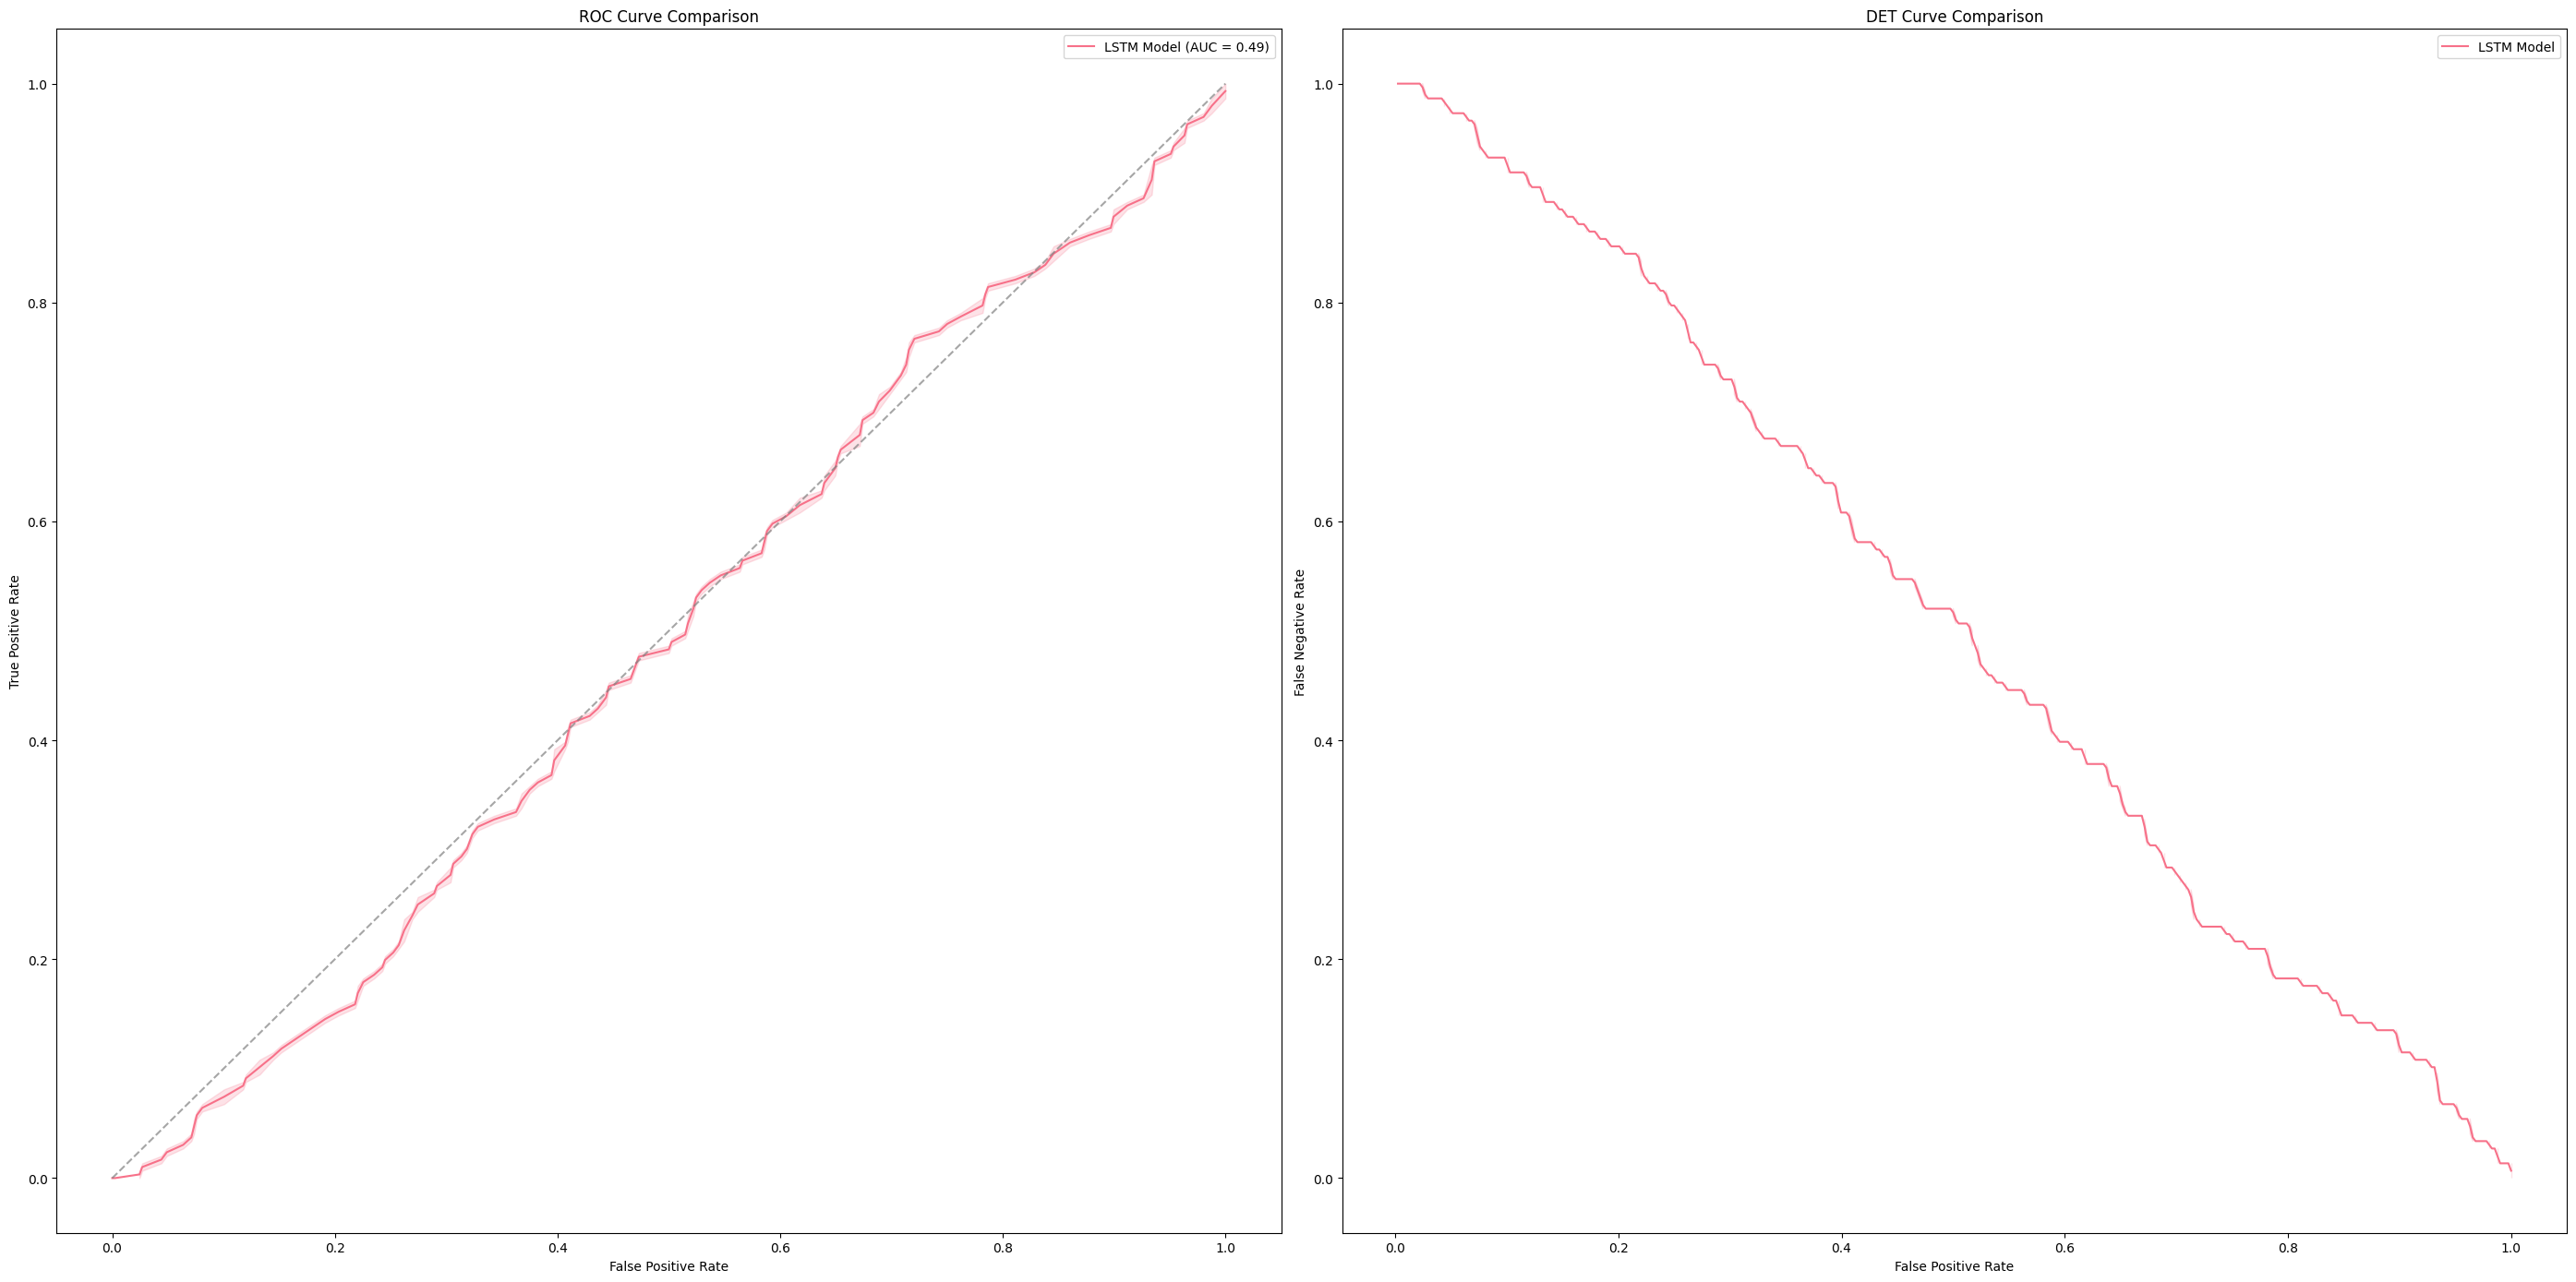

In [58]:
train_lstm_for_label("depression", X_train, y_train, X_val, y_val)

### Clasificador para Ansiedad


🔹 Training LSTM for ANXIETY classification...

Epoch [1/30], Loss: 0.6986
Epoch [2/30], Loss: 0.6857
Epoch [3/30], Loss: 0.6935
Epoch [4/30], Loss: 0.7026
Epoch [5/30], Loss: 0.6794
Epoch [6/30], Loss: 0.6932
Epoch [7/30], Loss: 0.6726
Epoch [8/30], Loss: 0.6734
Epoch [9/30], Loss: 0.7251
Epoch [10/30], Loss: 0.6899
Epoch [11/30], Loss: 0.6804
Epoch [12/30], Loss: 0.6693
Epoch [13/30], Loss: 0.6962
Epoch [14/30], Loss: 0.6761
Epoch [15/30], Loss: 0.6783
Epoch [16/30], Loss: 0.6882
Epoch [17/30], Loss: 0.7145
Epoch [18/30], Loss: 0.7506
Epoch [19/30], Loss: 0.6755
Epoch [20/30], Loss: 0.6793
Epoch [21/30], Loss: 0.6908
Epoch [22/30], Loss: 0.6463
Epoch [23/30], Loss: 0.6851
Epoch [24/30], Loss: 0.6622
Epoch [25/30], Loss: 0.6933
Epoch [26/30], Loss: 0.6194
Epoch [27/30], Loss: 0.6557
Epoch [28/30], Loss: 0.7135
Epoch [29/30], Loss: 0.6600
Epoch [30/30], Loss: 0.6195
anxiety Classification Report:
              precision    recall  f1-score   support

         0.0       0.58      0.93  

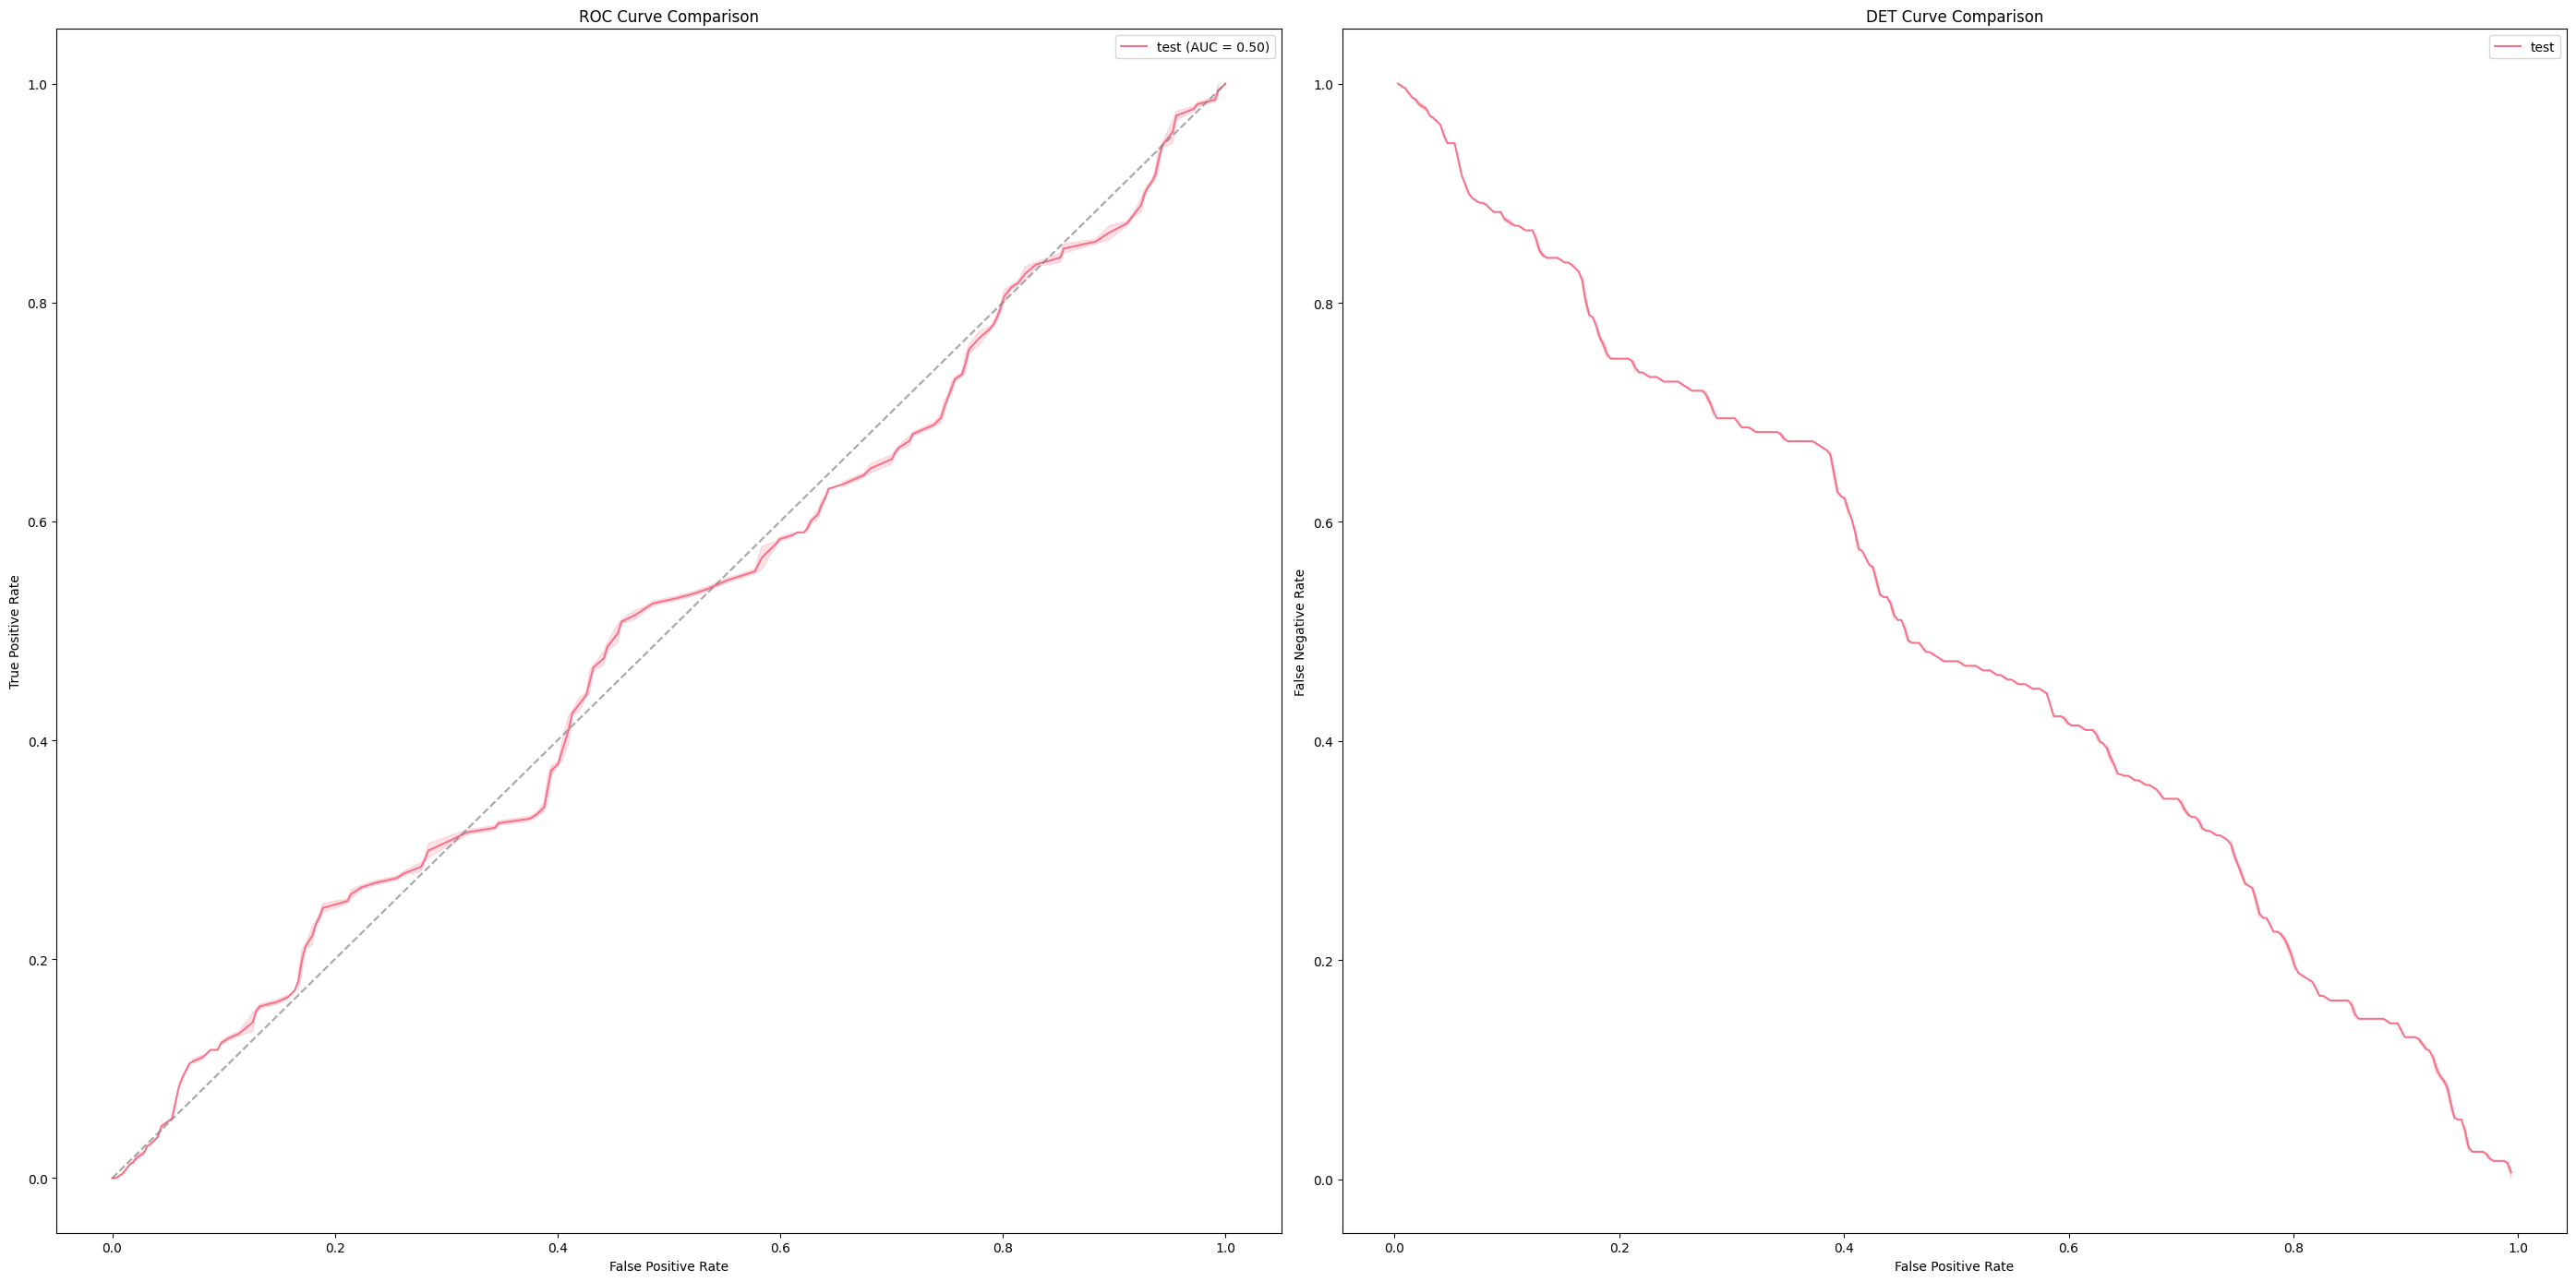

In [50]:
train_lstm_for_label("anxiety", X_train, y_train, X_val, y_val)

### Clasificador para Estrés


🔹 Training LSTM for STRESS classification...

Epoch [1/30], Loss: 0.6668
Epoch [2/30], Loss: 0.6853
Epoch [3/30], Loss: 0.7284
Epoch [4/30], Loss: 0.6687
Epoch [5/30], Loss: 0.6989
Epoch [6/30], Loss: 0.6777
Epoch [7/30], Loss: 0.6730
Epoch [8/30], Loss: 0.6814
Epoch [9/30], Loss: 0.6644
Epoch [10/30], Loss: 0.6779
Epoch [11/30], Loss: 0.6949
Epoch [12/30], Loss: 0.6884
Epoch [13/30], Loss: 0.6694
Epoch [14/30], Loss: 0.6879
Epoch [15/30], Loss: 0.6797
Epoch [16/30], Loss: 0.6774
Epoch [17/30], Loss: 0.6595
Epoch [18/30], Loss: 0.6456
Epoch [19/30], Loss: 0.6979
Epoch [20/30], Loss: 0.6378
Epoch [21/30], Loss: 0.6423
Epoch [22/30], Loss: 0.6496
Epoch [23/30], Loss: 0.6745
Epoch [24/30], Loss: 0.7118
Epoch [25/30], Loss: 0.7180
Epoch [26/30], Loss: 0.6692
Epoch [27/30], Loss: 0.7027
Epoch [28/30], Loss: 0.6333
Epoch [29/30], Loss: 0.6336
Epoch [30/30], Loss: 0.6846
stress Classification Report:
              precision    recall  f1-score   support

         0.0       0.56      0.84    

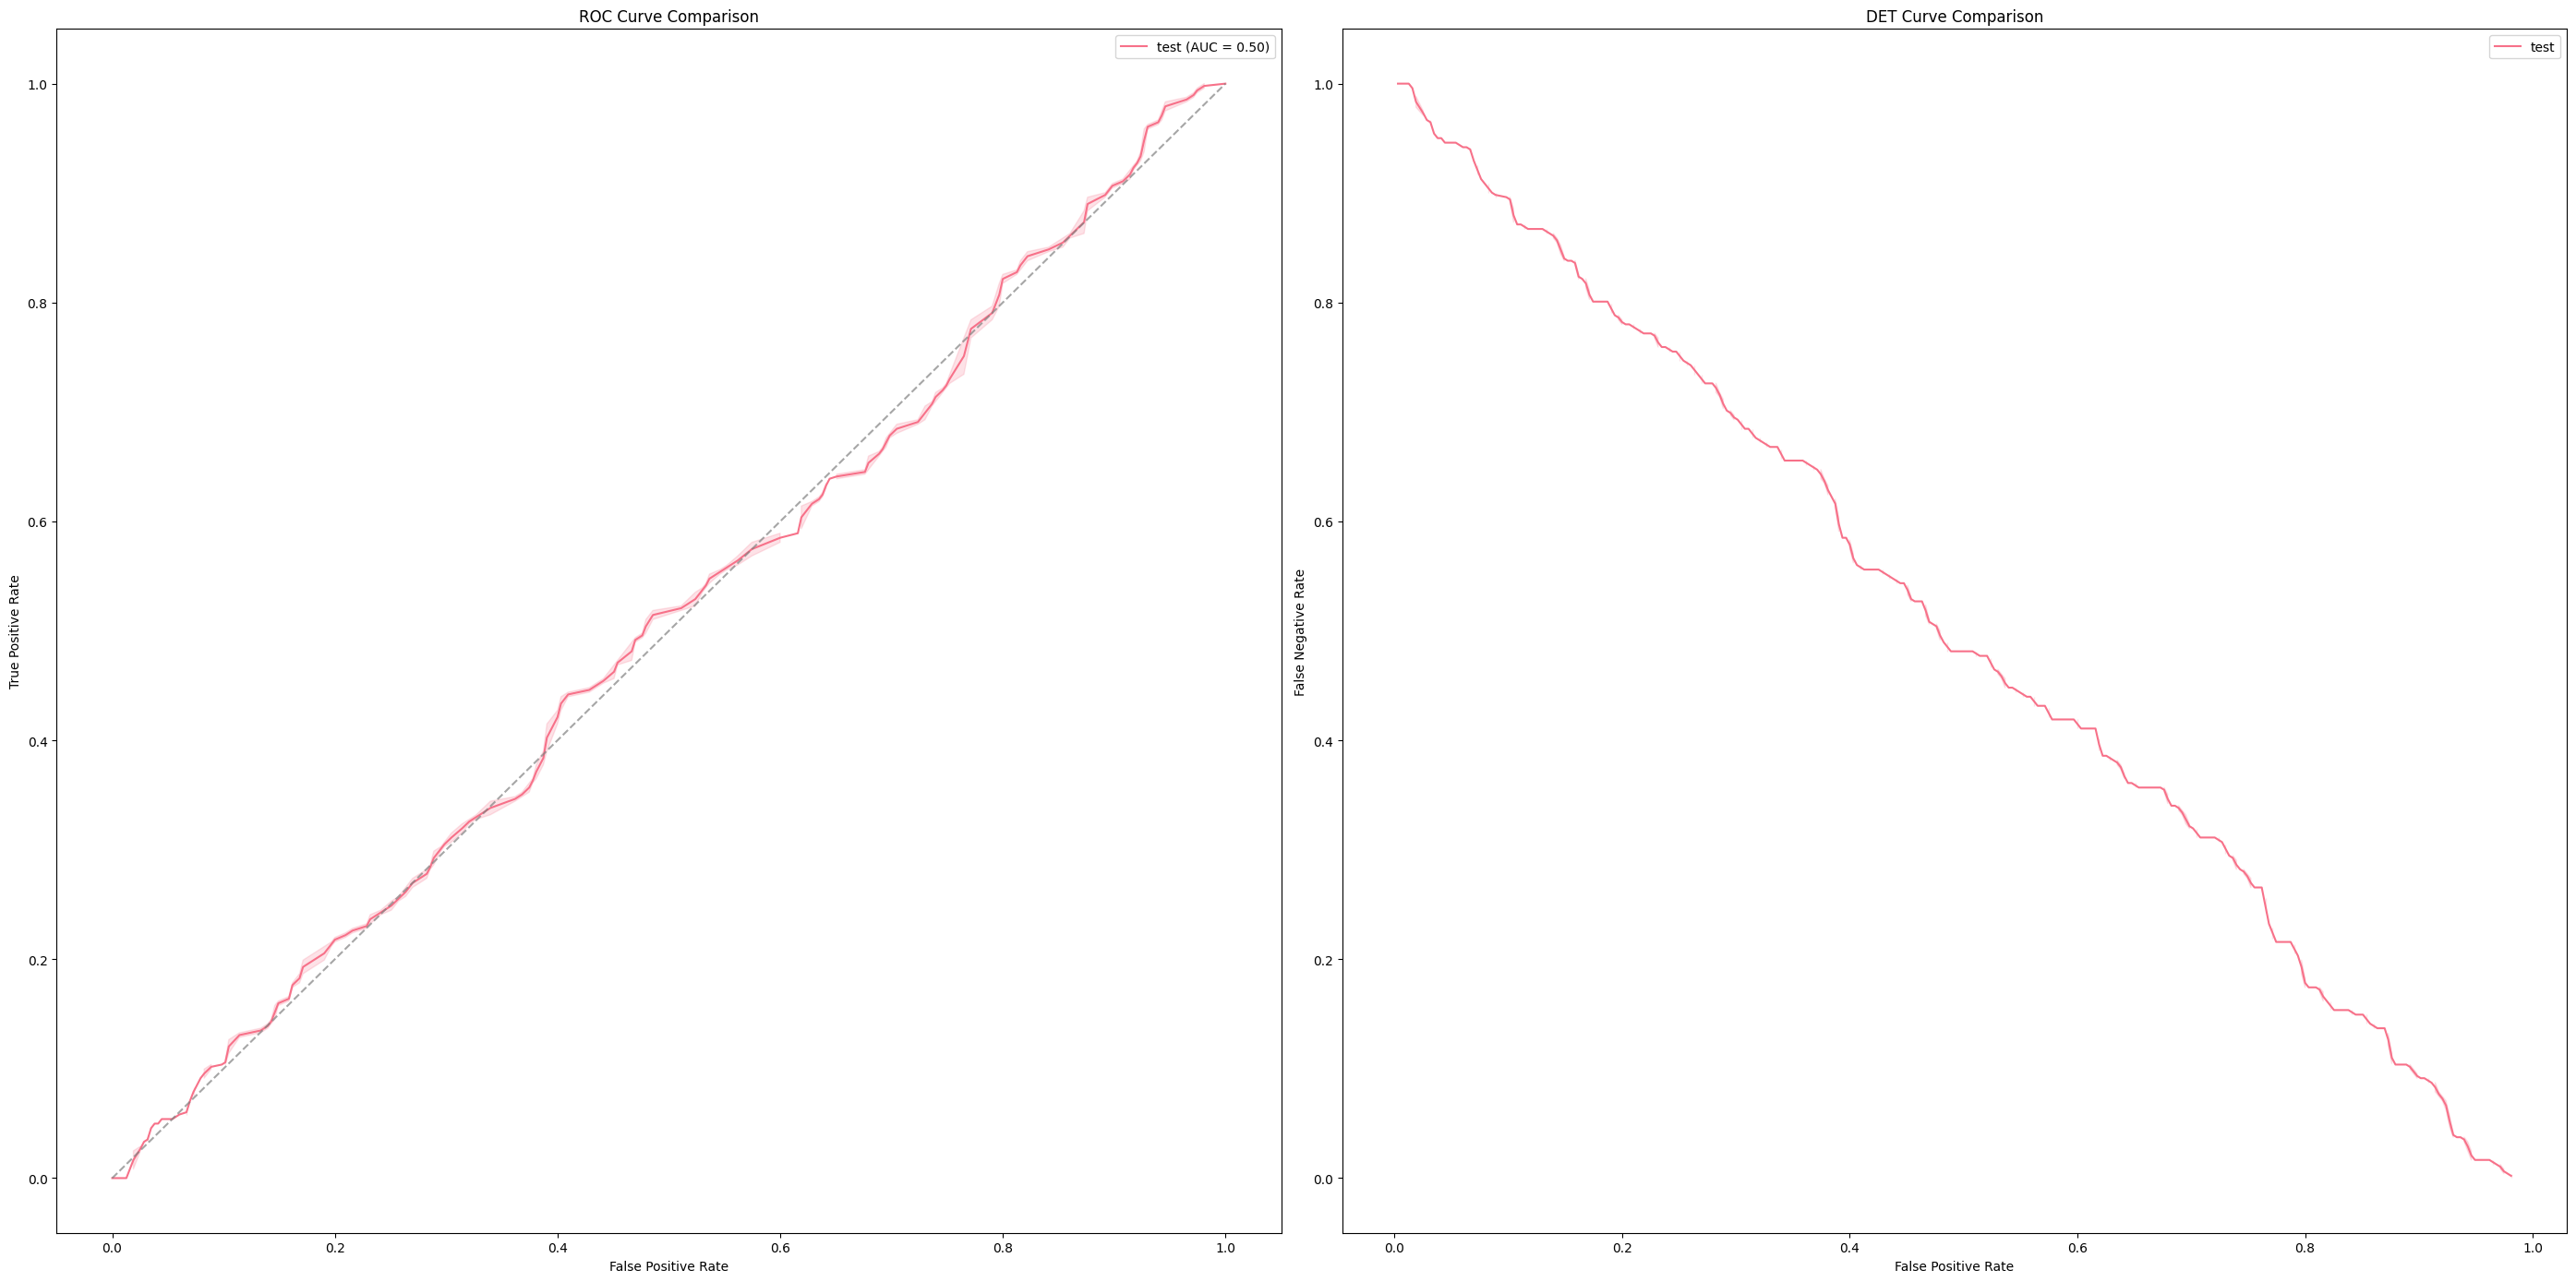

In [49]:
train_lstm_for_label("stress", X_train, y_train, X_val, y_val)

## Convolutional Neural Network (CNN)

# Graficas de la curva ROC y DET

#### Graficas de la curva ROC y DET de modelos con etiqueta de “Depression”

In [ ]:
models = {
    "SVM": SVC(**svm_depression_best_hyperparameters, probability=True, class_weight='balanced', random_state=42),
    "XGBoost": XGBClassifier(**xgb_depression_best_hyperparameters, random_state=42),
    "LightGBM": LGBMClassifier(**lgbm_depression_best_hyperparameters, random_state=42)
}

plt.figure(figsize=(14, 6))
palette = sns.color_palette("husl", len(models))
models_list_depression = []

for i, (name, model) in enumerate(models.items()):
    model.fit(X_train, y_train['depression'])
    y_prob = model.predict_proba(X_val)[:, 1]
    fpr, tpr, _ = roc_curve(y_val['depression'], y_prob)
    fpr_det, fnr_det, _ = det_curve(y_val['depression'], y_prob)

    models_list_depression.append(model)

    plt.subplot(1, 2, 1)
    sns.lineplot(x=fpr, y=tpr, label=f"{name} (AUC = {roc_auc_score(y_val['depression'], y_prob):.2f})",
                 color=palette[i])

    plt.subplot(1, 2, 2)
    sns.lineplot(x=fpr_det, y=fnr_det, label=name, color=palette[i])

plt.subplot(1, 2, 1)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", alpha=0.7)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()

plt.subplot(1, 2, 2)
plt.xlabel("False Positive Rate")
plt.ylabel("False Negative Rate")
plt.title("DET Curve Comparison")
plt.legend()

plt.tight_layout()
plt.show()


Perspectivas de la curva ROC:

Puntuaciones AUC (0,49–0,51): los modelos funcionan sólo ligeramente mejor que las conjeturas aleatorias, lo que indica una falta de características predictivas sólidas.

Rendimiento consistente en todos los modelos: ningún modelo supera significativamente a los demás

Información sobre la curva DET:

Las curvas DET muestran que las mejoras en FPR no mejoran drásticamente la FNR, lo que sugiere que los modelos están luchando con límites de decisión claros.


Guardamos la lista de la etiqueta “depression” para la siguiente sección.

In [ ]:
models_list_depression

#### Graficas de la curva ROC y DET de modelos con etiqueta de “Anxiety”

In [ ]:
models = {
    "SVM": SVC(**svm_anxiety_best_hyperparameters, probability=True, class_weight='balanced', random_state=42),
    "XGBoost": XGBClassifier(**xgb_anxiety_best_hyperparameters, random_state=42),
    "LightGBM": LGBMClassifier(**lgbm_anxiety_best_hyperparameters, random_state=42)
}

plt.figure(figsize=(14, 6))
palette = sns.color_palette("husl", len(models))
models_list_anxiety = []

for i, (name, model) in enumerate(models.items()):
    model.fit(X_train, y_train['anxiety'])
    y_prob = model.predict_proba(X_val)[:, 1]
    fpr, tpr, _ = roc_curve(y_val['anxiety'], y_prob)
    fpr_det, fnr_det, _ = det_curve(y_val['anxiety'], y_prob)

    models_list_anxiety.append(model)

    plt.subplot(1, 2, 1)
    sns.lineplot(x=fpr, y=tpr, label=f"{name} (AUC = {roc_auc_score(y_val['anxiety'], y_prob):.2f})",
                 color=palette[i])

    plt.subplot(1, 2, 2)
    sns.lineplot(x=fpr_det, y=fnr_det, label=name, color=palette[i])

plt.subplot(1, 2, 1)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", alpha=0.7)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()

plt.subplot(1, 2, 2)
plt.xlabel("False Positive Rate")
plt.ylabel("False Negative Rate")
plt.title("DET Curve Comparison")
plt.legend()

plt.tight_layout()
plt.show()


Perspectivas de la curva ROC:

AUC ligeramente superior (~0,50–0,51): aunque todavía son débiles, los modelos de ansiedad muestran una separación de clases ligeramente mejor en comparación con la depresión.

Los modelos basados en árboles funcionan ligeramente mejor: XGBoost y LightGBM tienen AUC más altas que la regresión logística y SVM, lo que sugiere que existen relaciones no lineales en los datos.

Información sobre la curva DET:

tasas de falsos positivos y falsos negativos se distribuyen de manera más uniforme, comparada con la grafica anterior en el label “depression”.


#### Graficas de la curva ROC y DET de modelos con etiqueta de "Stress"

In [ ]:
models = {
    "SVM": SVC(**svm_stress_best_hyperparameters, probability=True, class_weight='balanced', random_state=42),
    "XGBoost": XGBClassifier(**xgb_stress_best_hyperparameters, random_state=42),
    "LightGBM": LGBMClassifier(**lgbm_stress_best_hyperparameters, random_state=42)
}

plt.figure(figsize=(14, 6))
palette = sns.color_palette("husl", len(models))
models_list_stress = []

for i, (name, model) in enumerate(models.items()):
    model.fit(X_train, y_train['stress'])
    y_prob = model.predict_proba(X_val)[:, 1]
    fpr, tpr, _ = roc_curve(y_val['stress'], y_prob)
    fpr_det, fnr_det, _ = det_curve(y_val['stress'], y_prob)

    models_list_stress.append(model)

    plt.subplot(1, 2, 1)
    sns.lineplot(x=fpr, y=tpr, label=f"{name} (AUC = {roc_auc_score(y_val['stress'], y_prob):.2f})",
                 color=palette[i])

    plt.subplot(1, 2, 2)
    sns.lineplot(x=fpr_det, y=fnr_det, label=name, color=palette[i])

plt.subplot(1, 2, 1)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", alpha=0.7)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()

plt.subplot(1, 2, 2)
plt.xlabel("False Positive Rate")
plt.ylabel("False Negative Rate")
plt.title("DET Curve Comparison")
plt.legend()

plt.tight_layout()
plt.show()


Perspectivas de la curva ROC:

AUC similar a la ansiedad (~0,50–0,51): los modelos funcionan ligeramente mejor que las conjeturas aleatorias, pero aún carecen de un fuerte poder predictivo.

No hay un modelo destacado: a diferencia de la ansiedad, donde los modelos basados en árboles mejoraron ligeramente los resultados, todos los modelos parecen funcionar de manera similar para la detección del estrés.

Regresión logística y SVM bajan ligeramente en rendimiento.

Información sobre la curva DET:

Posible limitación del conjunto de datos: si ningún modelo mejora significativamente los resultados, es posible que las funciones no capturen patrones relacionados con el estrés de manera efectiva.


# Ajuste de Hiperparámetros de los mejores modelos

# Selección de mejor modelo

# Conclusiones

Lorem ipsum

# Referencias

S, G., Anand, A., Vijayvargiya, A., M, P., Moorthy, V., Kumar, S., & S, H. B. S. (2022, July 12). Emosens: Emotion recognition based on sensor data analysis using LIGHTGBM. arXiv.org. https://arxiv.org/abs/2207.14640

Costa, R. (2022). The CRISP-ML Methodology: A Step-by-Step Approach to Real-World Machine Learning Projects.

Piccini, N. (2023, julio 19). 101 machine learning algorithms for data science with cheat sheets. Data Science Dojo.